### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [2]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Krish"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Krish

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Krish

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")
result=llm.invoke(messages)

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 813,
  'prompt_tokens': 113,
  'total_tokens': 926,
  'completion_time': 0.863458441,
  'completion_tokens_details': {'reasoning_tokens': 67},
  'prompt_time': 0.006533705,
  'prompt_tokens_details': None,
  'queue_time': 0.015393526,
  'total_time': 0.869992146},
 'model_name': 'openai/gpt-oss-20b',
 'system_fingerprint': 'fp_565badff47',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [8]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [9]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000011ECA30E9F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000011ECA30F920>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
### Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Krish")])

In [13]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'fc_ece0517a-6bca-4ce2-b8fb-3de7806fb92f',
  'type': 'tool_call'}]

### Using messages as state

In [14]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [15]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [17]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="ashraf"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='ashraf')]

In [18]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', tool_calls=[], invalid_tool_calls=[])

In [19]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='57019c11-8bca-430a-833b-7f5edaf78aa2', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='ashraf', id='57f59fcf-3dfa-4b9c-8c13-fddb44e031b9'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='b9ff81d5-df1b-4ec4-96bf-63a1d7322e55', tool_calls=[], invalid_tool_calls=[])]

In [20]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

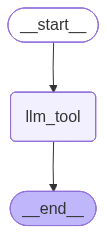

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
## invocation

messages=graph.invoke({"messages":"What is 5 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 5 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_cfd938bb-7cf1-4367-9715-82f289520972)
 Call ID: fc_cfd938bb-7cf1-4367-9715-82f289520972
  Args:
    a: 5
    b: 2


In [24]:
tools=[add]

In [25]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



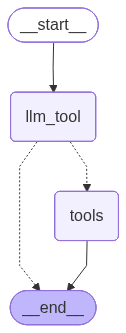

In [27]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [35]:
## invocation

messages=graph.invoke({"messages":"What is 4 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 4 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_17007d53-acff-4089-9e76-d96f938ba82d)
 Call ID: fc_17007d53-acff-4089-9e76-d96f938ba82d
  Args:
    a: 4
    b: 2


In [36]:
messages=graph.invoke({"messages":"What Machine Learnings"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learnings
================================== Ai Message ==================================

**Machine Learning (ML) – a quick primer**

| What it is | How it works | Typical use‑cases |
|------------|--------------|-------------------|
| **Machine Learning** is a subfield of artificial intelligence that teaches computers to learn patterns from data, rather than being explicitly programmed for every task. | 1. **Collect data** (images, text, sensor readings, etc.).  <br>2. **Choose a model** (e.g., decision tree, neural network).  <br>3. **Train** the model by feeding it data and letting it adjust its internal parameters to minimize error.  <br>4. **Validate** on unseen data to avoid overfitting.  <br>5. **Deploy** the model to make predictions or decisions. | • Spam filtering, image recognition, recommendation engines, fraud detection, autonomous vehicles, natural‑language understanding, medi

In [37]:
def show_conversation(state: State):
    print("Conversation History:")
    for message in state["messages"]:
        message.pretty_print()

In [38]:
show_conversation(messages)

Conversation History:
================================ Human Message =================================

What Machine Learnings
================================== Ai Message ==================================

**Machine Learning (ML) – a quick primer**

| What it is | How it works | Typical use‑cases |
|------------|--------------|-------------------|
| **Machine Learning** is a subfield of artificial intelligence that teaches computers to learn patterns from data, rather than being explicitly programmed for every task. | 1. **Collect data** (images, text, sensor readings, etc.).  <br>2. **Choose a model** (e.g., decision tree, neural network).  <br>3. **Train** the model by feeding it data and letting it adjust its internal parameters to minimize error.  <br>4. **Validate** on unseen data to avoid overfitting.  <br>5. **Deploy** the model to make predictions or decisions. | • Spam filtering, image recognition, recommendation engines, fraud detection, autonomous vehicles, natural‑langua